Usefull link: https://pymatching.readthedocs.io/en/latest/toric-code-example.html#Noisy-syndromes

In [1]:
# Allows us to import files from the base folder
import sys
import os
# Get the parent directory of the notebook's folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_dir)

# Imports
import jax
import jax.numpy as jnp

from pymatching import Matching

import matplotlib.pyplot as plt

from packages.quantum_error_correction import *
from packages.neural_network import *

from icecream import ic  # For debugging

key = jax.random.key(42)

# Initialize the QEC code that will be used

ic| nsq: 442, ndq: 441


Rate of non-trivial cases: 99.87%


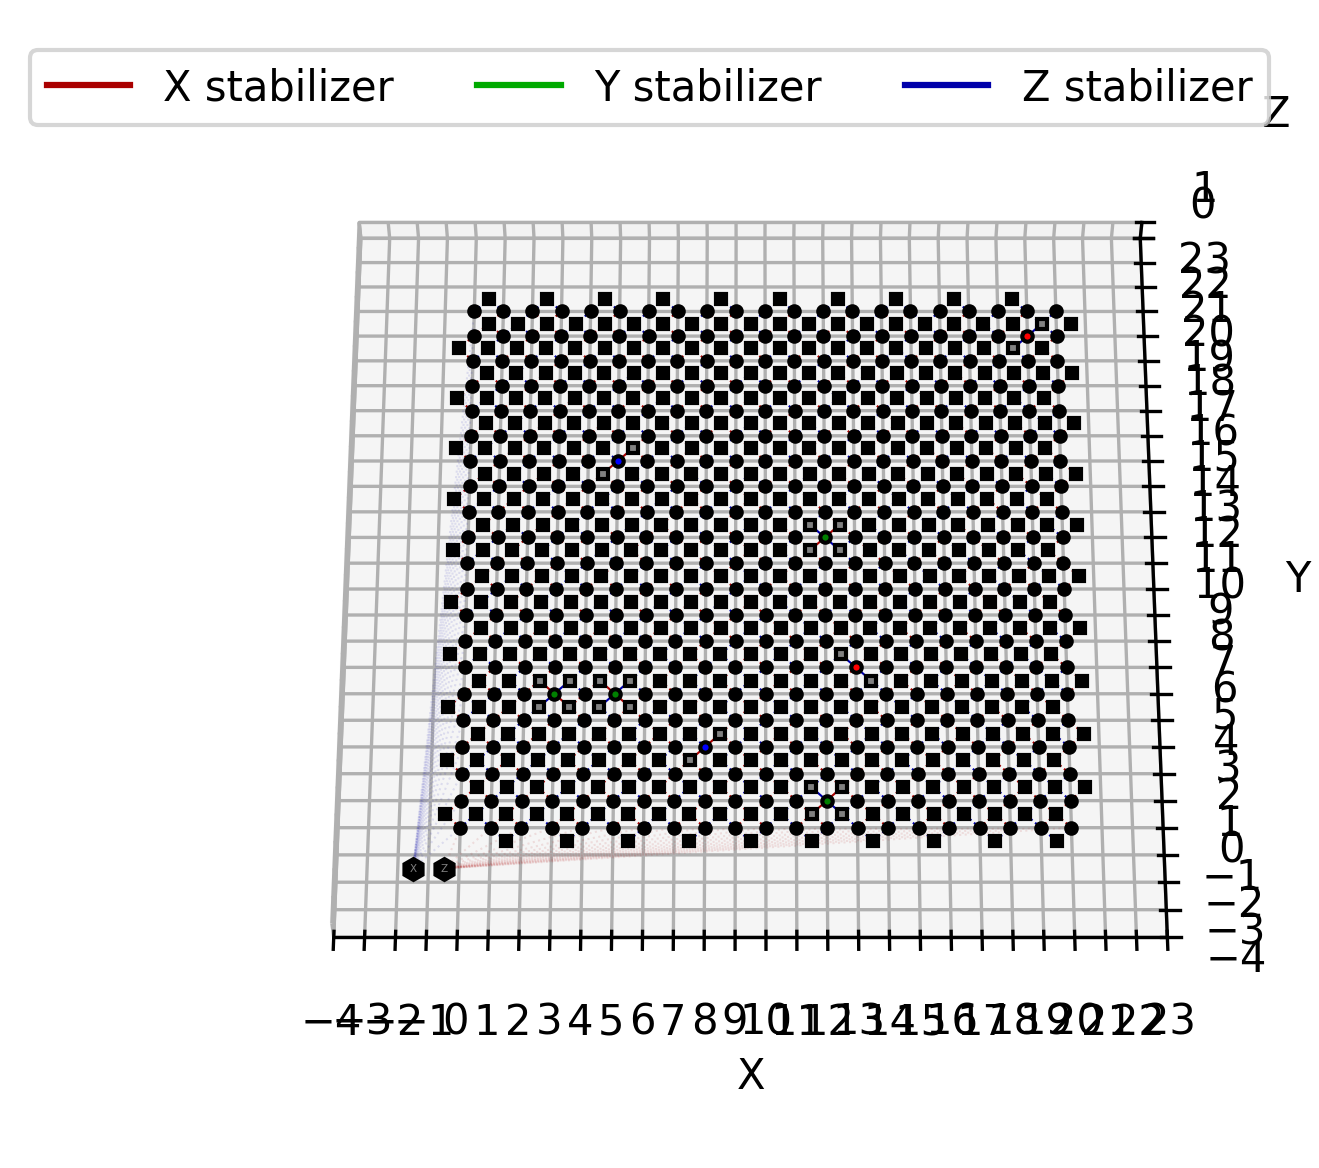

In [2]:
error_prob = [.005, .005, .005]
code_distance = 21

subkey, key = jax.random.split(key)
errors = jax_create_error_batch(*error_prob, size=code_distance**2, batch_size=1, key=subkey)

qec = QEC(surface_code_data_wls(d=code_distance))
Mx, My, Mz = qec.transformation_matrix()
nsq, ndq = Mx.shape
ic(nsq, ndq)
qec.show(errors=errors[0], marker_size=5);

print(f'Rate of non-trivial cases: {1-(1-sum(error_prob))**ndq:.2%}')

# Create a wrapper for the pymatching decoder

In [3]:
def mwpm_prediction_batch(syndromes: jnp.ndarray, Mx: jnp.ndarray, My: jnp.ndarray, Mz: jnp.ndarray) -> jnp.ndarray:
    """
    Uses the implementation of minimum weight perfect matching (MWPM) algorithm using ``pymatching``
    """
    check_matrix = jnp.append(Mx, Mz, axis=1)
    matching = Matching(check_matrix)

    recovery = jnp.array([matching.decode(syndrome) for syndrome in syndromes])
    d = recovery.shape[1] // 2
    rec_x, rec_z = recovery[:,:d], recovery[:,d:]
    return jnp.where(rec_x, jnp.where(rec_z, 2, 1), jnp.where(rec_z, 3, 0))
# def mwpm_prediction(syndromes: jnp.ndarray, Mx: jnp.ndarray, My: jnp.ndarray, Mz: jnp.ndarray) -> jnp.ndarray:
#     """
#     Uses the implementation of minimum weight perfect matching (MWPM) algorithm using ``pymatching``
#     """
#     check_matrix = jnp.append(Mx, Mz, axis=1)
#     matching = Matching(check_matrix)

#     recovery = matching.decode(syndromes)
#     d = recovery.shape[0] // 2
#     rec_x, rec_z = recovery[:d], recovery[d:]
#     return jnp.where(rec_x, jnp.where(rec_z, 2, 1), jnp.where(rec_z, 3, 0))

# mwpm_prediction_batch = lambda syndromes, Mx, My, Mz: jnp.array([mwpm_prediction(syndrome, Mx, My, Mz) for syndrome in syndromes])

# View the results

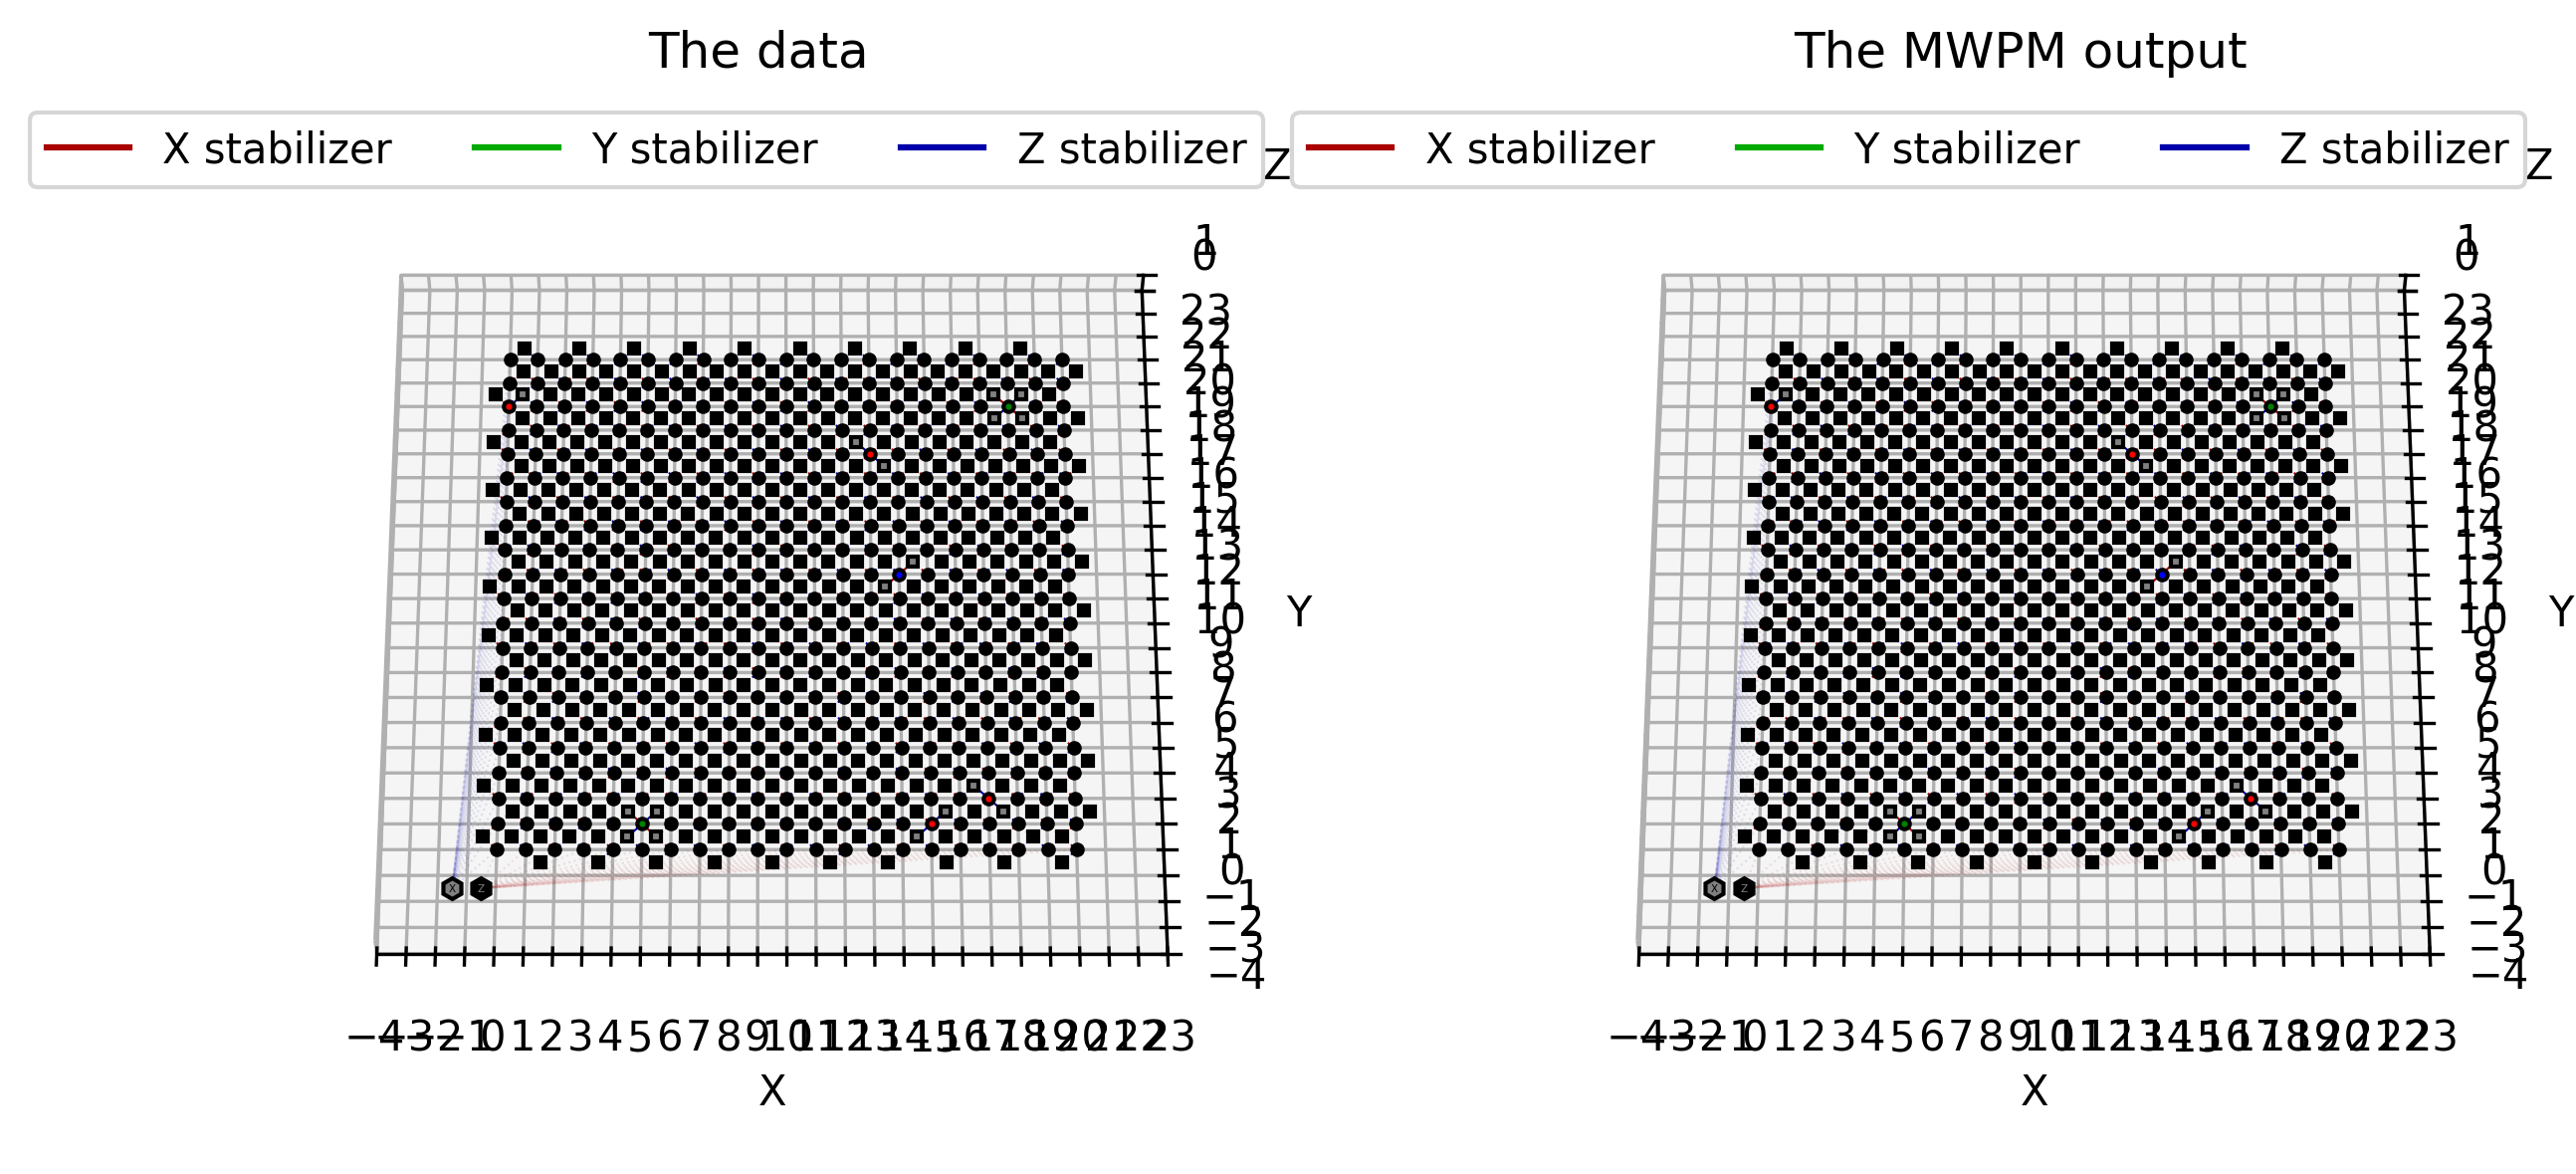

In [4]:
# Generate data
batch_size = 1
subkey, key = jax.random.split(key)
errors = jax_create_error_batch(
    px = error_prob[0],
    py = error_prob[1],
    pz = error_prob[2],
    size = ndq,
    batch_size = batch_size,
    key = subkey
)

syndromes = jax_get_syndromes_batch(Mx, My, Mz, errors)

# Run the mwpm
# The [:,:-2] and [:-2,:] or to not feed the decoder the logical stabilizers since those would normally not be accessiable
mwpm_correction = mwpm_prediction_batch(syndromes[:,:-2], Mx[:-2,:], My[:-2,:], Mz[:-2,:])

# Show the results
fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'projection': '3d'}, dpi=300)
fig.set_figwidth(10)
fig.set_figheight(10)
qec.show(axis=ax1, errors=errors[0], marker_size=5, title="The data")
qec.show(axis=ax2, errors=mwpm_correction[0], marker_size=5, title="The MWPM output")
plt.show()

# Calculate number of logical errors vs number of physical errors

In [5]:
resolution = 1000
batch_size = 50

errors = jnp.array([
    jax_create_error_batch(
        px = p,
        py = p,
        pz = p,
        size = ndq,
        batch_size = batch_size,
        key = subkey
    ) for p in jnp.linspace(0,1/3,resolution)
]).reshape((batch_size*resolution, code_distance**2))
errors.shape

(50000, 441)

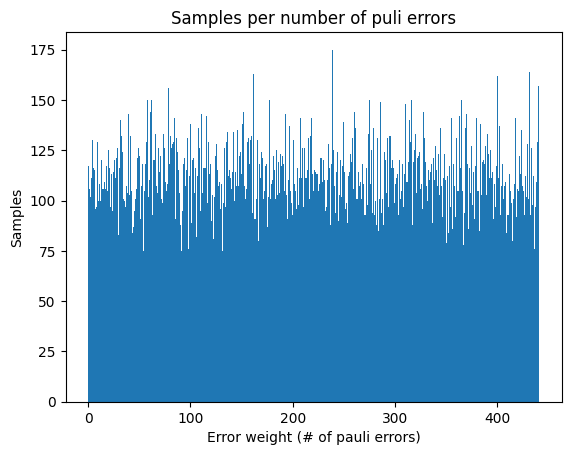

In [6]:
plt.plot()
plt.hist((errors != 0).sum(axis=1), bins=ndq+1)
plt.title("Samples per number of puli errors")
plt.xlabel("Error weight (# of pauli errors)")
plt.ylabel("Samples")
plt.show()

In [7]:
syndromes = jax_get_syndromes_batch(Mx, My, Mz, errors)
mwpm_correction = mwpm_prediction_batch(syndromes[:,:-2], Mx[:-2,:], My[:-2,:], Mz[:-2,:])
mwpm_syndromes = jax_get_syndromes_batch(Mx, My, Mz, mwpm_correction)
logical_errors = (syndromes[:,-2:] + mwpm_syndromes[:,-2:]) % 2

In [8]:
I = [0 for _ in range(code_distance**2+1)]
X = [0 for _ in range(code_distance**2+1)]
Y = [0 for _ in range(code_distance**2+1)]
Z = [0 for _ in range(code_distance**2+1)]
C = [0 for _ in range(code_distance**2+1)]

for physical_errors, logical_error in zip(errors, logical_errors):
    error_distance = int((physical_errors != 0).sum())
    C[error_distance] += 1
    if all(logical_error == jnp.array([0,0])):
        I[error_distance] += 1
    elif all(logical_error == jnp.array([1,0])):
        X[error_distance] += 1
    elif all(logical_error == jnp.array([1,1])):
        Y[error_distance] += 1
    elif all(logical_error == jnp.array([0,1])):
        Z[error_distance] += 1
    else:
        raise ValueError(f"Something went wrong: {physical_errors = }, {logical_error = }")
    
I = jnp.array(I)
X = jnp.array(X)
Y = jnp.array(Y)
Z = jnp.array(Z)
C = jnp.array(C)            

pI = I/C
pX = X/C
pY = Y/C
pZ = Z/C

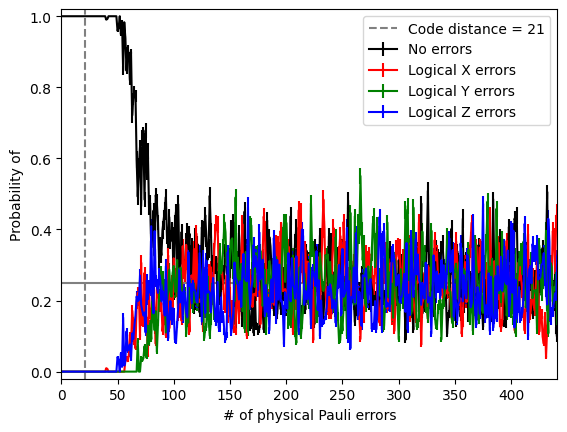

In [9]:
plt.figure()
plt.errorbar(jnp.arange(0, ndq+1), pI, yerr=pI*(1-pI)/jnp.sqrt(C), c='k', label="No errors")
plt.errorbar(jnp.arange(0, ndq+1), pX, yerr=pX*(1-pX)/jnp.sqrt(C), c='r', label="Logical X errors")
plt.errorbar(jnp.arange(0, ndq+1), pY, yerr=pY*(1-pY)/jnp.sqrt(C), c='g', label="Logical Y errors")
plt.errorbar(jnp.arange(0, ndq+1), pZ, yerr=pZ*(1-pZ)/jnp.sqrt(C), c='b', label="Logical Z errors")
plt.vlines(code_distance, -.02, 1.02, color='gray', ls='--', label=f"Code distance = {code_distance}")
plt.hlines(1/4, 0, code_distance**2, color='gray', ls='-', zorder=-1)
plt.xlim(0, code_distance**2)
plt.ylim(-.02, 1.02)
plt.legend()
plt.xlabel("# of physical Pauli errors")
plt.ylabel("Probability of")
plt.show()